In [24]:
# https://www.kaggle.com/datasets/trolukovich/apparel-images-dataset/data
# link al dataset 

In [25]:
#librerías instaladas en el entorno virtual

# !pip install tensorflow
# !pip install tensorflow-datasets

In [26]:
#librerías de python importadas

# generales 

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras


# preprocess
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils  import load_img
from tensorflow.keras.utils import img_to_array
import sklearn as sk
from sklearn.model_selection import train_test_split

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
#import pickle

## Configuracion previa hardware

In [27]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 7 GB = 7 * 1024 MB = 7168 MB
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=7168)]
        )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "GPU(s) físicas,", len(logical_gpus), "GPU(s) lógicas")
    except RuntimeError as e:
        print(e)


1 GPU(s) físicas, 1 GPU(s) lógicas


## Preprocessing CASIA 2.0 Image Tampering Detection Dataset

In [28]:
path_general = r"D:\1_data_science\trabajo_especializacion_datasets\Apparel_images_dataset"
list_dir_pg = os.listdir(path_general)
#armo diccionario de las clases y las imágenes
dicc_imgs = {}
for i in list_dir_pg:
    path = os.path.join(path_general, i)
    list_dir = os.listdir(path)
    dicc_imgs[i] = list_dir
#Me fijo los formatos únicos para cada clase, todos son jpg.
dicc_formatos = {}
for x in dicc_imgs.keys():
    formato = set([i.split(".")[-1] for i in dicc_imgs[x]])
    dicc_formatos[x] = formato

In [29]:
#diccionario labels
dicc_labels = {}
for i, clase in enumerate (dicc_imgs.keys()):
    dicc_labels[clase] = i

In [30]:
def cargar_imagen(img_path):
    try:
        # Cargar la imagen y redimensionarla
        img = load_img(img_path, target_size=(224, 224))
        # Convertir la imagen a un array
        img_array = np.array(img)
        # Reorganizar las dimensiones correctamente
        reshaped_img_array = img_array.reshape(1, 224, 224, 3)
        # Preprocesar la imagen
        preprocessed_img = preprocess_input(reshaped_img_array)
        return preprocessed_img
    except Exception as e:
        print(f"Error procesando la imagen {img_path}: {e}")
        return None

def dataset_builder(dataset_path):
    dataset = {}
    valid_formats = {".jpg", ".jpeg", ".tif", ".bmp", ".png"}
    
    # Itera por las carpetas de la ruta al dataset
    for class_folder in os.listdir(dataset_path):
        dataset[class_folder] = []
        class_path = os.path.join(dataset_path, class_folder)
        for img in os.listdir(class_path):
            img_path = os.path.join(class_path, img)
            _, img_format = os.path.splitext(img_path)
            if img_format.lower() in valid_formats:
                preprocessed_img = cargar_imagen(img_path)
                if preprocessed_img is not None:  # Validar si se procesó correctamente
                    dataset[class_folder].append(preprocessed_img)
                    
    return dataset
    

In [ ]:
#Armo los vectores X e Y para el entrenamiento y prueba
def armar_vectores(dicc_preproceded_imgs, dicc_labels):
        
    X = []
    Y = []
    for indice in dicc_preproceded_imgs.keys():
        clase = dicc_preproceded_imgs[indice]
        label = dicc_labels[indice]
        largo_clase = len(clase)//2
        largo_label = len(clase)//2
        clase = clase[:largo_clase]
        label = label
        
        for img in clase:
            X.append(img)
            Y.append(label)

    print ("largo de X", len(X), "largo de Y", len(Y))

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

    print ("largo de X_train", len(X_train), "largo de y_train", len(y_train))
    print ("largo de X_test", len(X_test), "largo de y_test", len(y_test))
    X_train = np.vstack(X_train)  # Convierte la lista en un array de NumPy
    X_test = np.vstack(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return X_train, X_test, y_train, y_test

largo de X 5688 largo de Y 5688
largo de X_train 3981 largo de y_train 3981
largo de X_test 1707 largo de y_test 1707


In [35]:
dicc_preproceded_imgs = dataset_builder(path_general)
X_train, X_test, y_train, y_test = armar_vectores(dicc_preproceded_imgs, dicc_labels)

## Definiendo la Arquitectura de la VGG16

In [38]:
def entrenar_modelo_inicial(dicc_labels, X_train, X_test, y_train, y_test):
    model = VGG16()
    categories = len(dicc_labels.keys()) # 24 clases del diccionario de labels
    #elijo las layers que conservo y las freezo para no modficarlas en el training
    input = (224, 224)
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

    for layer in model.layers:
        layer.trainable = False
    # creo nueva capa para clasificar y la agrego al modelo final
    nueva_dense = tf.keras.layers.Dense (categories, activation = 'softmax')
    model_final = Model(inputs = model.inputs, outputs = nueva_dense(model.output))
    model_final.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    history = model_final.fit(X_train[0:3000], y_train[0:3000], validation_data=(X_test[0:3000], y_test[0:3000]), epochs=10, batch_size=8)
    score = model_final.evaluate(X_test[0:3000],  y_test[0:3000], verbose=0)
    model.save("modelo_inicial.h5")
    return history, score
    

In [ ]:
history, score = entrenar_modelo_inicial(dicc_labels=dicc_labels, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

In [39]:
def graficar_modelo(history, score):
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
def graficar_modelo2(history, score):
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
    x = list(range(1,10+1))
    vy = history.history['val_loss']
    ty = history.history['loss']
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    plt.show()
    score = model_final.evaluate(X_test[0:3000],  y_test[0:3000], verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

## Fine-tuning

In [21]:
def entrenar_modelo_fine_tuned(dicc_labels, X_train, X_test, y_train, y_test):

    model = load_model('initial_model.h5')

    for layer in model.layers[:-3]:
        layer.trainable = False
    for layer in model.layers[-3:]:
        layer.trainable = True
    for layer in model.layers:
        print(layer, layer.trainable)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    history = model.fit(X_train[0:3000], y_train[0:3000], validation_data=(X_test[0:3000], y_test[0:3000]), epochs=10, batch_size=8)
    score = model_final.evaluate(X_test[0:3000],  y_test[0:3000], verbose=0)
    return history , score
    

<keras.engine.input_layer.InputLayer object at 0x0000029E5085EB90> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000029E5085F7C0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000029E43D3DE70> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000029E5085D810> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000029E5085F3D0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000029E7F63D630> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000029E7F63E3B0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000029E7F63DFF0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000029E7F63D1B0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000029E7F63FD60> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000029E7F63EC20> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000029E7F63F910> False
<keras.layers.convolutional.conv2d.Conv2D object

In [22]:
model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [23]:
history = model_final.fit(X_train[0:3000], y_train[0:3000], validation_data=(X_test[0:3000], y_test[0:3000]), epochs=10, batch_size=8)

Epoch 1/10
375/375 [==============================] - 34s 89ms/step - loss: 1.7611 - accuracy: 0.6797 - val_loss: 0.8521 - val_accuracy: 0.7827
Epoch 2/10


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_1/fc1/MatMul/MatMul_1' defined at (most recent call last):
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Admin\AppData\Local\Temp\ipykernel_10056\963183320.py", line 1, in <module>
      history = model_final.fit(X_train[0:3000], y_train[0:3000], validation_data=(X_test[0:3000], y_test[0:3000]), epochs=10, batch_size=8)
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\Admin\anaconda3\envs\tensorgpu\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model_1/fc1/MatMul/MatMul_1'
OOM when allocating tensor with shape[25088,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_1/fc1/MatMul/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_26588]

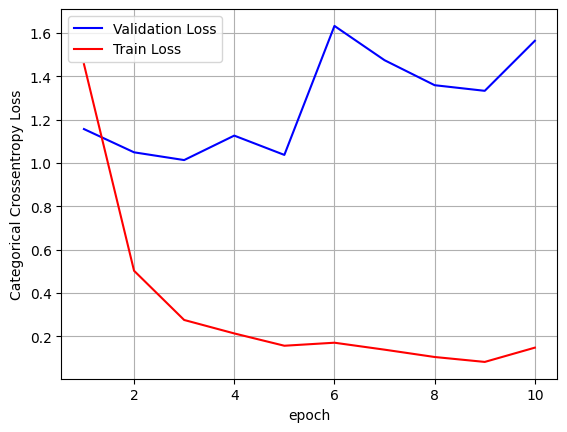

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,10+1))
vy = history.history['val_loss']
ty = history.history['loss']
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
plt.show()